In [1]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import scipy.signal as sig

In [2]:
fps = 30 

# output path 
out_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\hc_video_output\MM_HC\2024-07-30\000_raw_pose_data'

# import yolo 
yolo_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\hc_video_output\MM_HC\2024-07-30\000_raw_pose_data\MM_HC_17ft_gait_vertical_right_yolo.csv'

In [3]:
yolo_df = pd.read_csv(yolo_path, index_col = 0)
yolo_df.head()

,X,Y,label,frame
0,0.00000,0.00000,nose,0
1,0.00000,0.00000,left_eye,0
2,0.00000,0.00000,right_eye,0
3,418.01028,178.36707,left_ear,0
4,579.52844,177.58612,right_ear,0


In [4]:
yolo_df['label'].value_counts()

label
nose              781
left_wrist        781
left_ankle        781
right_knee        781
left_knee         781
right_hip         781
left_hip          781
right_wrist       781
right_elbow       781
left_eye          781
left_elbow        781
right_shoulder    781
left_shoulder     781
right_ear         781
left_ear          781
right_eye         781
right_ankle       781
Name: count, dtype: int64

In [5]:
# clean missing yolo data 

# if both x and Y = zero, replace with NaN
#yolo_df[['X', 'Y']] = yolo_df[['X', 'Y']].mask((yolo_df['X'] == 0) & (yolo_df['Y'] == 0), np.nan)

In [6]:
# pixel height 

l_eye_yolo_df = yolo_df.loc[yolo_df['label'] == 'left_eye']
l_eye_yolo_df.set_index('frame', inplace=True)
l_ankle_yolo_df = yolo_df.loc[yolo_df['label'] == 'left_ankle']
l_ankle_yolo_df.set_index('frame', inplace=True)


l_ankle_yolo_df = l_ankle_yolo_df.copy()
l_ankle_yolo_df.loc[:, 'approx_height_Y_pix'] = abs(l_eye_yolo_df['Y'] - l_ankle_yolo_df['Y'])
l_ankle_yolo_df.loc[:, 'approx_height_Y_pix_smooth'] = l_ankle_yolo_df['approx_height_Y_pix'].rolling(window=25, min_periods = 1).mean()

In [7]:
# drop l ankle specific columns 
height_df = l_ankle_yolo_df.drop(columns = ['X', 'Y', 'label'])
height_df.reset_index(inplace=True)
height_df.tail()

,frame,approx_height_Y_pix,approx_height_Y_pix_smooth
776,779,1282.89913,1248.313022
777,780,1282.41432,1251.195981
778,781,1281.85563,1254.019537
779,782,1281.97150,1256.767389
780,783,1283.16170,1259.588337


<Axes: xlabel='frame', ylabel='approx_height_Y_pix'>

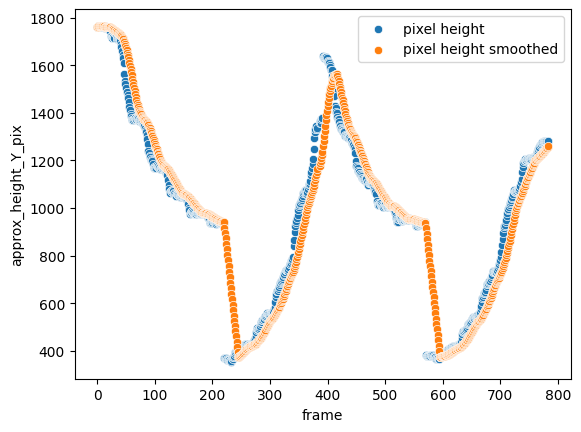

In [8]:
max_frame = yolo_df['frame'].max()

sns.scatterplot(x = 'frame', y = 'approx_height_Y_pix', data = height_df, label = 'pixel height')
sns.scatterplot(x = 'frame', y = 'approx_height_Y_pix_smooth', data = height_df, label = 'pixel height smoothed')

## Set up time groupings to calculate change over 


In [9]:
# add "time_group" label column, will use to group 
height_df['time_group'] = height_df['frame'] / (fps)
height_df['time_group'] = height_df['time_group'].apply(math.floor)
height_df.head()

,frame,approx_height_Y_pix,approx_height_Y_pix_smooth,time_group
0,0,1762.4410,1762.441000,0
1,1,1763.0765,1762.758750,0
2,2,1765.1533,1763.556933,0
3,3,1763.9994,1763.667550,0
4,4,1764.9269,1763.919420,0


In [10]:
# identify peaks and valleys in pixel height (approximate turn locations) 
peaks, _ = sig.find_peaks(height_df['approx_height_Y_pix_smooth'], distance = fps)
valleys, _ = sig.find_peaks(-height_df['approx_height_Y_pix_smooth'], distance = fps)
peaks_valleys = np.concatenate((peaks, valleys))

6
413
545
13
245
541
592


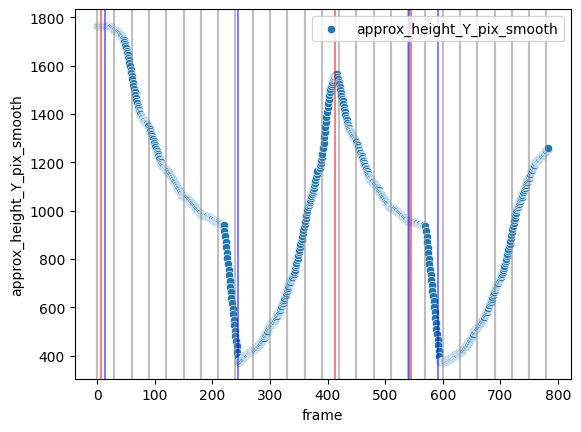

In [11]:
sns.scatterplot(x = 'frame', y = 'approx_height_Y_pix_smooth', data = height_df, label = 'approx_height_Y_pix_smooth')
for time_group in height_df['time_group'].unique(): 
    plt.axvline(x = time_group * (fps), color = 'grey', alpha = 0.5)

for peak in peaks:
    print(peak)
    plt.axvline(x = peak, color = 'red', alpha = 0.5)

for valley in valleys:
    print(valley)
    plt.axvline(x = valley, color = 'blue', alpha = 0.5)

## Idea 1 - pixels/height (in) 

In [12]:
# pixels per inch 
# my height in inches (5ft 10 inches) 
mm_height_in = 70 
height_df['height_pix_per_in'] = height_df['approx_height_Y_pix_smooth'] / mm_height_in 
height_df.head()

,frame,approx_height_Y_pix,approx_height_Y_pix_smooth,time_group,height_pix_per_in
0,0,1762.4410,1762.441000,0,25.177729
1,1,1763.0765,1762.758750,0,25.182268
2,2,1765.1533,1763.556933,0,25.193670
3,3,1763.9994,1763.667550,0,25.195251
4,4,1764.9269,1763.919420,0,25.198849


<Axes: xlabel='frame', ylabel='height_pix_per_in'>

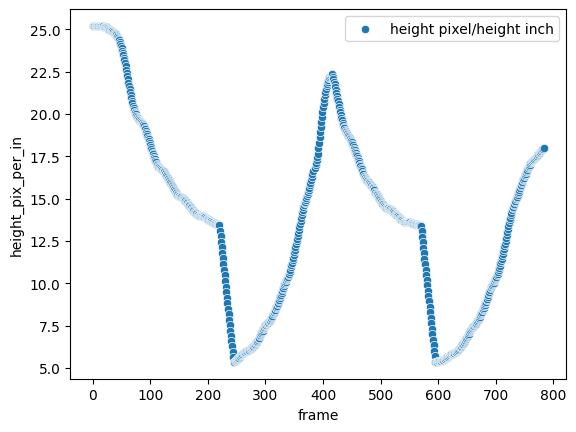

In [13]:
sns.scatterplot(x = 'frame', y = 'height_pix_per_in', data = height_df, label = 'height pixel/height inch')

In [14]:
def calc_pix_per_in_per_second(start_frame, end_frame, df, fps): 
    start_row = df.loc[df['frame'] == start_frame]
    end_row = df.loc[df['frame'] == end_frame]

    start_pix_per_in = start_row['height_pix_per_in'].iloc[0]
    end_pix_per_in = end_row['height_pix_per_in'].iloc[0]
    
    delta_pix_per_in = abs(start_pix_per_in - end_pix_per_in)
    # divide by starting pixel height (if closer, likeley greater change in pixels / inch) 
    delta_pix_per_in = delta_pix_per_in / start_pix_per_in

    delta_seconds = (end_frame - start_frame) / fps

    pix_per_in_per_second = round(delta_pix_per_in / delta_seconds, 2)
    print(pix_per_in_per_second)
    
    return pix_per_in_per_second


In [15]:
# loop through each time_group in video and calc change in pix per time_group 
pix_per_in_per_sec_all = []

for current_sec_group in height_df['time_group'].unique():
    current_height_df = height_df.loc[height_df['time_group'] == current_sec_group]
   # print(current_height_df.shape)
    current_start_frame = current_height_df['frame'].iloc[0]
    current_end_frame = current_height_df['frame'].iloc[-1]

    # if this current time_group group contains peak or valley, skp 
    if current_height_df.loc[current_start_frame: current_end_frame, 'frame'].isin(peaks_valleys).any():
        print('Skipped - contains peak or valley') 
        current_pix_per_in_per_sec = np.nan
    else: 
        current_pix_per_in_per_sec = calc_pix_per_in_per_second(current_start_frame,
                                                                current_end_frame,
                                                                height_df, 
                                                                fps) 

    # change in (pixel/in) / second 
#    current_pix_per_in_per_sec = calc_pix_per_in_per_second(current_start_frame,
                                                         #   current_end_frame,
                                                         #   height_df, 
                                                          #  fps) 

    pix_per_in_per_sec_all.append(current_pix_per_in_per_sec) 

Skipped - contains peak or valley
0.1
0.14
0.13
0.1
0.07
0.04
0.49
Skipped - contains peak or valley
0.24
0.28
0.4
0.29
Skipped - contains peak or valley
0.16
0.13
0.09
0.06
Skipped - contains peak or valley
Skipped - contains peak or valley
0.1
0.25
0.29
0.35
0.26
0.1
0.07


Text(0, 0.5, 'pix_per_in_per_sec_all')

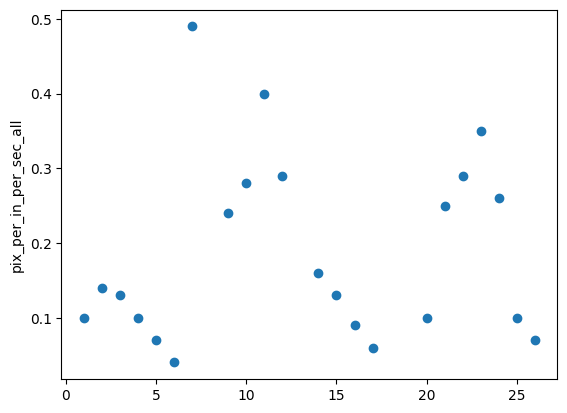

In [16]:
# plot all values per group  
plt.scatter(x = height_df['time_group'].unique(), y = pix_per_in_per_sec_all)
plt.ylabel('pix_per_in_per_sec_all')

In [17]:
# get median of all values - remove extreme values and hopefully turning? 

## Idea 2 - change in pix/in from first frame 
max and min - bigger change in pixels per inch if walking faster? 

In [18]:
height_df.head()

,frame,approx_height_Y_pix,approx_height_Y_pix_smooth,time_group,height_pix_per_in
0,0,1762.4410,1762.441000,0,25.177729
1,1,1763.0765,1762.758750,0,25.182268
2,2,1765.1533,1763.556933,0,25.193670
3,3,1763.9994,1763.667550,0,25.195251
4,4,1764.9269,1763.919420,0,25.198849


In [19]:
# mean pix/in from first 10 frames with pixel height data 
first_height = height_df.dropna(subset=['height_pix_per_in']).iloc[0:20]
first_pix_per_in = first_height['height_pix_per_in'].median()
# change from current frame to first frame 
height_df['pix_per_in_change'] = first_pix_per_in - height_df['height_pix_per_in']


<Axes: xlabel='frame', ylabel='pix_per_in_change'>

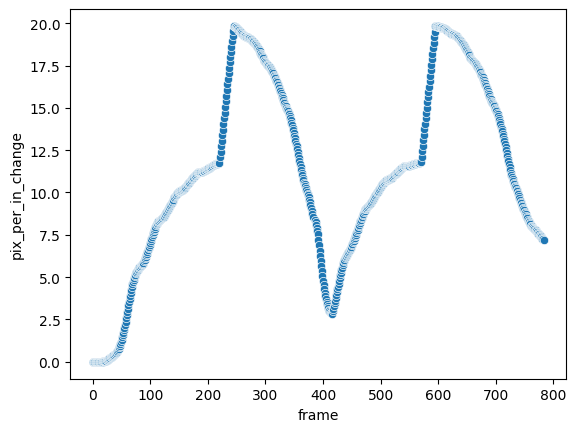

In [20]:
sns.scatterplot(x = 'frame', y = 'pix_per_in_change', data = height_df)

In [21]:
# calc mean, min, max - don't need for loop 

## Idea 3 - normalized changes in pixel size 
- account for differences in starting position by dividing by pixel size and taking log 

In [22]:
height_df.head()

,frame,approx_height_Y_pix,approx_height_Y_pix_smooth,time_group,height_pix_per_in,pix_per_in_change
0,0,1762.4410,1762.441000,0,25.177729,0.014028
1,1,1763.0765,1762.758750,0,25.182268,0.009488
2,2,1765.1533,1763.556933,0,25.193670,-0.001914
3,3,1763.9994,1763.667550,0,25.195251,-0.003494
4,4,1764.9269,1763.919420,0,25.198849,-0.007093


In [23]:
def calc_pix_size_change(start_frame, end_frame, df, fps): 
    start_row = df.loc[df['frame'] == start_frame]
    end_row = df.loc[df['frame'] == end_frame]

    # height in pixel at start and end of time group 
    pix_h_start = start_row['approx_height_Y_pix_smooth'].iloc[0]
    pix_h_end = end_row['approx_height_Y_pix_smooth'].iloc[0]

    # for consistency, only calculate when walking toward camera - height is getting bigger as walking toward 
    if pix_h_end > pix_h_start:
        # Change in pixel height from start to end 
        delta_pix_h = pix_h_end - pix_h_start

        # change in pixel height relative to start
        delta_pix_h_rel = delta_pix_h / pix_h_start

        # logarithmic scaling 
        delta_pix_h_log = math.log(pix_h_end / pix_h_start)

    else: 
        delta_pix_h = np.nan
        delta_pix_h_rel = np.nan
        delta_pix_h_log = np.nan


    return delta_pix_h, delta_pix_h_rel, delta_pix_h_log
    

In [24]:
depth_proxies_all = []

for current_sec_group in height_df['time_group'].unique():
    current_height_df = height_df.loc[height_df['time_group'] == current_sec_group]

    current_start_frame = current_height_df['frame'].iloc[0]
    current_end_frame = current_height_df['frame'].iloc[-1]

    # if this current time_group group contains peak or valley, skp 
    if current_height_df.loc[current_start_frame: current_end_frame, 'frame'].isin(peaks_valleys).any():
        print('Skipped - contains peak or valley') 
        delta_pix_h = np.nan
        delta_pix_h_rel = np.nan
        delta_pix_h_log = np.nan
    else: 
        delta_pix_h, delta_pix_h_rel, delta_pix_h_log  = calc_pix_size_change(current_start_frame, current_end_frame, height_df, fps)

    # combine all time group increments into one array 

    depth_proxies_all.append({'start_frame' : current_start_frame,
                             'delta_pix_h' : delta_pix_h, 
                             'delta_pix_h_rel' : delta_pix_h_rel,
                             'delta_pix_h_log' : delta_pix_h_log})

                             
# convert array to df 
depth_proxies_all_df = pd.DataFrame(depth_proxies_all) 

Skipped - contains peak or valley
Skipped - contains peak or valley
Skipped - contains peak or valley
Skipped - contains peak or valley
Skipped - contains peak or valley


In [25]:
depth_proxies_all_df

,start_frame,delta_pix_h,delta_pix_h_rel,delta_pix_h_log
0,0,NaN,NaN,NaN
1,30,NaN,NaN,NaN
2,60,NaN,NaN,NaN
3,90,NaN,NaN,NaN
4,120,NaN,NaN,NaN
5,150,NaN,NaN,NaN
6,180,NaN,NaN,NaN
7,210,NaN,NaN,NaN
8,240,NaN,NaN,NaN
9,270,98.753677,0.233273,0.209672


In [26]:
plt.scatter(x = start_frames_all, y = delta_pix_h_all, color = 'orange', label = 'delta_pix_h_all')
for time_group in height_df['time_group'].unique(): 
    plt.axvline(x = time_group * (fps), color = 'grey', alpha = 0.5)

for peak in peaks:
    print(peak)
    plt.axvline(x = peak, color = 'red', alpha = 0.5)

for valley in valleys:
    print(valley)
    plt.axvline(x = valley, color = 'blue', alpha = 0.5)
plt.legend()

NameError: name 'start_frames_all' is not defined

In [ ]:
plt.scatter(x = start_frames_all, y = delta_pix_h_rel_all, color = 'blue', label = 'delta_pix_h_rel_all')

for time_group in height_df['time_group'].unique(): 
    plt.axvline(x = time_group * (fps), color = 'grey', alpha = 0.5)

for peak in peaks:
    print(peak)
    plt.axvline(x = peak, color = 'red', alpha = 0.5)

for valley in valleys:
    print(valley)
    plt.axvline(x = valley, color = 'blue', alpha = 0.5)
plt.legend()

In [ ]:
plt.scatter(x = start_frames_all, y = delta_pix_h_log_all, color = 'red', label = 'delta_pix_h_log_all')

for time_group in height_df['time_group'].unique(): 
    plt.axvline(x = time_group * (fps), color = 'grey', alpha = 0.5)

for peak in peaks:
    print(peak)
    plt.axvline(x = peak, color = 'red', alpha = 0.5)

for valley in valleys:
    print(valley)
    plt.axvline(x = valley, color = 'blue', alpha = 0.5)
plt.legend()